# Block A: Data Cleaning & Merging

## 1. Loading Data

In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sb
from sklearn import linear_model

activities = pd.read_csv('activities.csv', parse_dates = ['Date'])
users = pd.read_csv('users.csv', parse_dates = ['RegDate', 'DOB'])

Quick preview of the data:

In [2]:
users.head(1)

,UserId,Country,DOB,Gender,RegDate
0,1326865,DE,1988-05-04,M,2016-03-24


In [3]:
activities.head(1)

,UserId,Date,Revenue
0,1326865,2017-02-19,17.05


### Number of Variables and Observations

In [4]:
activities.shape

(22642, 3)

In [5]:
users.shape

(5807, 5)

- Activities
    - 22643 observations
    - 3 variables
   
- Users
    - 5807 oversations
    - 5 variables
    
Let us check if for any NaN values:

In [6]:
activities.isnull().values.any()

False

In [7]:
users.isnull().values.any()

False

## 2. Number of Male and Female users in Dataset

In [8]:
users.value_counts('Gender')

Gender
M    2909
     1481
F    1417
dtype: int64

We have 2909 male, 1417 female, and 1481 users with no available information (whitespace in this case).

## 3. Merge Datasets

Before merging let's check if all userIDs are present in the activities dataset, and all userIDs in the activities dataset are indeed present in the users dataset:

In [9]:
users[~users.UserId.isin(activities.UserId)]

,UserId,Country,DOB,Gender,RegDate
478,3022012,GB,1968-03-18,M,2016-10-26
2068,3183514,GB,1972-04-27,F,2016-10-25
2070,3183537,GB,1972-04-27,F,2017-01-04
2228,3188926,GB,1992-07-08,F,2017-02-11
2902,3214796,GB,1973-09-06,M,2017-01-31
3204,3228231,GB,1985-08-24,F,2016-12-26
3605,3248027,GB,1966-09-15,M,2017-04-27
5484,3330595,GB,1996-04-01,M,2017-05-05
5690,3341993,GB,1975-05-29,M,2017-03-20
5796,3346950,GB,1982-12-25,F,2016-12-05


In [10]:
activities[~activities.UserId.isin(users.UserId)]

,UserId,Date,Revenue


From this result we know that 10 users have not done any activities. For simplicity of further calculations let us assume that each of those users has one activity with zero revenue on their registration date.

In [11]:
user_activities = users.merge(activities, on='UserId', how='outer')

# Fill values
user_activities.Revenue.fillna(0, inplace=True)

# Assume user has an activity on the registration date. Zero revenue is added later.
row_has_NaN = (user_activities.isnull()).any(axis=1)
user_activities.loc[row_has_NaN, 'Date'] = user_activities.RegDate[row_has_NaN]

user_activities.head(1)

,UserId,Country,DOB,Gender,RegDate,Date,Revenue
0,1326865,DE,1988-05-04,M,2016-03-24,2017-02-19,17.05


 Days since registration and age:

In [12]:
user_activities['DSR'] = user_activities.Date - user_activities.RegDate
user_activities['Age'] = user_activities.RegDate - pd.to_datetime(user_activities.DOB)

Mean and median total revenue per user:

In [13]:
revenue = user_activities.groupby('UserId').agg(TotalRevenue=('Revenue', 'sum'))
revenue.describe()

,TotalRevenue
count,5807.000000
mean,511.807730
std,3054.599213
min,0.000000
25%,25.580000
50%,80.000000
75%,240.000000
max,104917.000000


The median is much smaller than the mean. That means that several users earn a lot of with respect to the rest of the group.

Also we can expect that the distribution is not normal.

## 4. Distribution of revenue by user

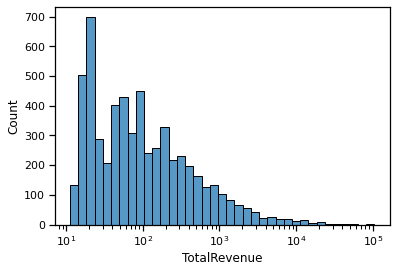

In [14]:
with sb.plotting_context("notebook"):
    # Remove zero values to avoid negative infinity in the log plot
    sb.histplot(revenue.loc[revenue.TotalRevenue > 0] , x="TotalRevenue", log_scale=True);

## 5. Revenue in first day and week since registration
The idea of this section is to build a dataframe with all the information that we will need later, i.e.,  a dataframe with columns:

| UserId | Gender | Country | Age | TotalRevenue | Week1Revenue | Day1Revenue | 

In [15]:
# Revenue per first Day
filtered_1_day = user_activities[user_activities.DSR < pd.Timedelta(1, "d")]
day_1_revenue = filtered_1_day.groupby(['UserId'])\
                .agg(Day1Revenue = ('Revenue', 'sum')).reset_index()

# Revenue per First Week
# Assume week starts on registration date, so first 7 days are given by indices 0,1,2,3,4,5,6
filtered_1_week = user_activities[user_activities.DSR < pd.Timedelta(7, "d")]
week_1_revenue = filtered_1_week.groupby(['UserId'])\
                .agg(Week1Revenue = ('Revenue', 'sum')).reset_index()

### Merge results from previous cell in one dataframe

In [16]:
dfg = user_activities.groupby(['UserId','Gender', 'Country', 'Age'])
dummy1 = dfg.agg(TotalRevenue = ('Revenue', 'sum')).reset_index()
dummy2 = dummy1.merge(week_1_revenue, on='UserId', how='outer')
df = dummy2.merge(day_1_revenue, on='UserId', how='outer')

# If there was no activity on day or week 1 then revenue was zero
df.Week1Revenue.fillna(0, inplace=True)
df.Day1Revenue.fillna(0, inplace=True)

# Assume Gender Male when there is no available gender
df.replace(' ', 'M', inplace=True)
df.tail()

,UserId,Gender,Country,Age,TotalRevenue,Week1Revenue,Day1Revenue
5802,3347222,M,FR,18199 days,230.27,56.80,37.52
5803,3347251,F,GB,13080 days,30.00,30.00,30.00
5804,3347333,M,GB,10659 days,30.00,30.00,30.00
5805,3347367,F,US,7909 days,17.05,17.05,17.05
5806,3347450,M,US,8301 days,42.63,42.63,42.63


### Sanity Check
In the table above we should observe: total revenue >= week 1 revenue >= day 1 revenue. 

### Average week 1 revenue

From the Table below the average week 1 revenue is 166.

In [17]:
df.describe()

,UserId,Age,TotalRevenue,Week1Revenue,Day1Revenue
count,5.807000e+03,5807,5807.000000,5807.000000,5807.000000
mean,3.173594e+06,13323 days 16:29:25.593249408,511.807730,166.056609,95.086246
std,2.319768e+05,4113 days 16:14:44.439623168,3054.599213,579.323055,322.200608
min,1.326865e+06,6505 days 00:00:00,0.000000,0.000000,0.000000
25%,3.162306e+06,10252 days 12:00:00,25.580000,20.000000,17.050000
50%,3.214801e+06,12505 days 00:00:00,80.000000,40.000000,29.190000
75%,3.278615e+06,15740 days 12:00:00,240.000000,105.000000,85.135000
max,3.347450e+06,42529 days 00:00:00,104917.000000,19350.000000,10200.000000


# Block B

## 6. Statistical Significance

Let's visualize the difference in week 1 revenue by gender with 95% confidence intervals:

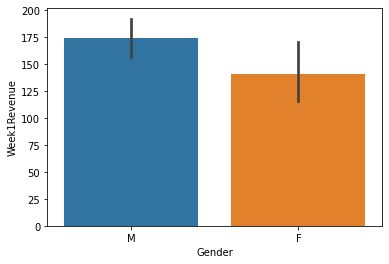

In [18]:
sb.barplot(x='Gender', y='Week1Revenue', data=df);

From the distribution of revenue by user we know that the data is skewed, so we should perform a non-parametric test. 

The Mann Whitney U Test makes no assumption about the distribution of the population, and it can take sample sizes of different sizes as input.

In [19]:
ttest_res = scipy.stats.mannwhitneyu(
                      (df.loc[df.Gender=='M', 'Week1Revenue']).to_numpy()
                    , (df.loc[df.Gender=='F', 'Week1Revenue']).to_numpy()
                      )
ttest_res

MannwhitneyuResult(statistic=2803698.5, pvalue=1.0914613065885675e-08)

According to the p-value printed above (1.09e-08) the difference between men and women is very significant. 

## 7. Country where first week revenue difference is largest

### Computing the difference for each country

In [20]:
df.groupby(['Country', 'Gender']).mean()

UserId  TotalRevenue  Week1Revenue  Day1Revenue
Country Gender                                                       
DE      F       3.117358e+06    216.432687     92.497413    52.314677
        M       3.191690e+06    320.842191    134.923562    80.713401
FR      F       3.152638e+06    501.179067    189.108800    87.116133
        M       3.167049e+06    591.082730    225.429056   126.618138
GB      F       3.145570e+06    641.749753    182.231190    94.644833
        M       3.197422e+06    548.840400    197.949611   114.946489
Other   F       3.078948e+06    448.067289     62.334267    35.360356
        M       3.133556e+06    279.730437    114.954699    63.077093
US      F       3.188557e+06    374.329559    118.619736    74.923392
        M       3.202551e+06    783.490899    181.792241   109.456886

From the table above the difference is largest in the United States.

## 8. Relationship between country, gender and week 1 revenue

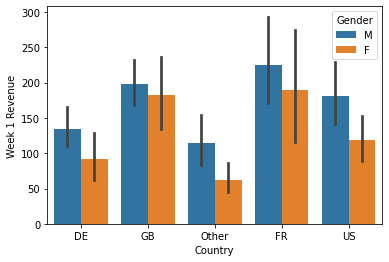

In [21]:
sb.barplot(x="Country", y="Week 1 Revenue", hue="Gender"
           , data=df.rename(columns = {'Week1Revenue':'Week 1 Revenue'}, inplace = False));

## 9. Linear regression model

Since the linear model needs floats as inputs, we have to convert the categorical inputs to number inputs. This is done with `pd.get_dummies()`

In [22]:
# Prepare data
dummies = pd.get_dummies(df[['Gender', 'Country']])
X = dummies
X['Age'] = df['Age'].dt.days/365.
X['Day1Revenue'] = df['Day1Revenue']
y = df.Week1Revenue
X.head()

,Gender_F,Gender_M,Country_DE,Country_FR,Country_GB,Country_Other,Country_US,Age,Day1Revenue
0,0,1,1,0,0,0,0,27.906849,0.0
1,0,1,0,0,1,0,0,44.586301,0.0
2,0,1,0,0,1,0,0,32.520548,0.0
3,0,1,0,0,0,1,0,39.358904,0.0
4,1,0,0,0,0,1,0,34.967123,0.0


Now the model can be set-up:

In [23]:
# set up model
lm = linear_model.LinearRegression()
model = lm.fit(X,y)

# Print the model coefficients
print("Model Coefficients:")
[print(j ,"{:0.1f}".format(i)) for j, i in zip(X.columns, model.coef_)]

print('\nOrder of variables with most impact on prediction (highest to lowest):')
[print(i) for i in X.columns[np.flip(np.argsort(abs(model.coef_)))]];




Model Coefficients:
Gender_F -1.8
Gender_M 1.8
Country_DE -13.0
Country_FR 19.3
Country_GB 8.3
Country_Other -10.4
Country_US -4.2
Age 0.9
Day1Revenue 1.3

Order of variables with most impact on prediction (highest to lowest):
Country_FR
Country_DE
Country_Other
Country_GB
Country_US
Gender_M
Gender_F
Day1Revenue
Age


### Variables with most impact on final result
According to the coefficients of the model, living in France or Germany has the most impact on the result of the prediction. The age is the least important, changing country from Germany to France has about the same about as a 25 years age increase.

## 10. Predicted revenue of French, German and British Women

First let's create the input Dataframe for the model. Each row contains one user with the characteristics asked in the question.

In [24]:
# Create Dataframe for input to the model

#                             F  M  DE FR GB Other US  Age  Day1Revenue
df2 = pd.DataFrame(np.array([[1, 0, 0, 1, 0, 0,     0, 40,  20] 
                            ,[1, 0, 1, 0, 0, 0,     0, 40,  20] 
                            ,[1, 0, 0, 0, 1, 0,     0, 40,  20.]])
                            ,columns=['F', 'M', 'DE', 'FR', 'GB', 'Other', 'US', 'Age', 'Day1Revenue'])

df2

,F,M,DE,FR,GB,Other,US,Age,Day1Revenue
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,40.0,20.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,40.0,20.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,40.0,20.0


The data above looks correct, now it can be fed into the model:

In [25]:
lm.predict(df2)

array([84.10953772, 51.83117972, 73.07722318])

 From the above result, we expect French, German, and British women to earn GBP 84, 51, 73 respectively

### Linear Model Sanity Check

By looking at the plot of means of week 1 revenue, one can see that in general French women earn more than British women, who in turn earn more than German women. This agrees with the previous prediction, where the same pattern is observed.